<H1>Notebook for Deep Learning-based Binary Diagnosis of DR using the IDRID Disease Grading dataset</H1>

[![dataset](https://img.shields.io/badge/Open_in_Colab-orange)](https://githubtocolab.com/Sohambasu07/DR_2021/blob/master/notebooks/Blood_Vessel_Segmentation_DRIVE_dataset.ipynb)
[![paper](https://img.shields.io/badge/Springer-Full_Paper-blue)](https://doi.org/10.1007/978-981-16-1543-6_16) 
[![dataset](https://img.shields.io/badge/IDRID-Dataset-yellow)](https://ieee-dataport.org/open-access/indian-diabetic-retinopathy-image-dataset-idrid#files)

In [ ]:
import tensorflow as tf
import os
import numpy as np
import cv2 as cv
import random
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, InputLayer, concatenate, Conv2D, MaxPooling2D, Flatten, Dense, UpSampling2D, Reshape, Dropout, Activation, Permute
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras import backend as K
from tensorflow.keras.utils import plot_model as plot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import Model
import pandas as pd
print(tf.__version__)

2.3.0


In [ ]:
from google.colab import drive
drive.mount("/content/drive", force_remount=False)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install --upgrade wandb
!wandb login 757b8017fb0121dcce596722c170d2c2386a4773

     |████████████████████████████████| 1.8MB 8.4MB/s 
     |████████████████████████████████| 133kB 31.2MB/s 
     |████████████████████████████████| 163kB 30.4MB/s 
     |████████████████████████████████| 102kB 12.9MB/s 
     |████████████████████████████████| 102kB 11.5MB/s 
     |████████████████████████████████| 71kB 8.0MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-cp36-none-any.whl size=6489 sha256=377b606ff180aff93f38128113fac513e02427d60898c270ebd9b7e9db787add
  Stored in directory: /root/.cache/pip/wheels/68/39/1a/5e402bdfdf004af1786c8b853fd92f8c4a04f22aad179654d1
  Created wheel for watchdog: filename=watchdog-0.10.4-cp36-none-any.whl size=74841 sha256=6ef458aea125f699cbd34438863d18cc5c566a0e1e05ddc941ea8fe05347b347
  Stored in directory: /root/.cache/pip/wheels/9e/11/04/5160b8815b0cc7cf574bdc6d053e510169ec264c8791b4ec3a
  Created wheel for pathtools: filename=pathtools-0.1.2-cp36-none-any.whl size=8785 sha256=acc173d9008685b143b2f04cf47835c263560b5519b1

In [ ]:
drive_path = '/content/drive/My Drive/DRProjectData/'
trainds_path = '/IDRID_Datasets/Disease_Grading/Groundtruths/'
testds_path = '/IDRID_Datasets/Disease_Grading/Groundtruths/'
train_img_dir = '/IDRID_Datasets/Disease_Grading/Original_Images/Training_Set/'
test_img_dir = '/IDRID_Datasets/Disease_Grading/Original_Images/Testing_Set'

In [ ]:
#train_file = 'DR_Grading_Training Labels.csv'
train_file = 'DR_Binary_Training Labels.csv'

#test_file = 'DR_Grading_Testing Labels.csv'
test_file = 'DR_Binary_Testing Labels.csv'

traindf = pd.read_csv(drive_path + trainds_path + train_file, dtype=str)
traindf['Image name'] = traindf['Image name'].astype(str) + '.jpg'
testdf = pd.read_csv(drive_path + testds_path + test_file, dtype=str)
testdf['Image name'] = testdf['Image name'].astype(str) + '.jpg'
len(traindf)
#print(traindf['Image name'][0])

413

In [ ]:
traindf.tail(20)

,Image name,Retinopathy grade
393,IDRiD_394.jpg,1
394,IDRiD_395.jpg,0
395,IDRiD_396.jpg,0
396,IDRiD_397.jpg,1
397,IDRiD_398.jpg,1
398,IDRiD_399.jpg,0
399,IDRiD_400.jpg,0
400,IDRiD_401.jpg,1
401,IDRiD_402.jpg,1
402,IDRiD_403.jpg,1


In [ ]:
testdf.tail(20)

,Image name,Retinopathy grade
83,IDRiD_084.jpg,1
84,IDRiD_085.jpg,1
85,IDRiD_086.jpg,1
86,IDRiD_087.jpg,1
87,IDRiD_088.jpg,1
88,IDRiD_089.jpg,1
89,IDRiD_090.jpg,0
90,IDRiD_091.jpg,1
91,IDRiD_092.jpg,0
92,IDRiD_093.jpg,0


In [ ]:
def imageProc(nimgs):
  temp_data_path = '/content/DR_Train/'
  if os.path.exists(temp_data_path) == False:
    os.mkdir(temp_data_path)
  for img_num in range(nimgs):
    file_name = traindf['Image name'][img_num]#.astype(str)
    data_path = drive_path + train_img_dir + file_name
    img = cv.imread(data_path, -1)

    if(img_num%10 == 0):
      print(img_num)

    #RESIZING IMAGES
    h = img.shape[0]
    w = img.shape[1]
    perc = 500/w
    w1 = 500
    h1 = int(h*perc)
    img_rs = cv.resize(img,(w1,h1))


    #SPLITTING INTO GREEN CHANNEL
    _,img_gc,_ = cv.split(img_rs)
    img_gc[img_gc < 20] = 0

    #PERFORMING CLAHE
    clahe = cv.createCLAHE(clipLimit=4.0, tileGridSize=(4,4))
    img_cl1 = clahe.apply(img_gc)

    #WRITING IMAGES TO TEMP DISK
    cv.imwrite(temp_data_path+file_name, img_cl1)
  
  print(img_num)

  return temp_data_path

In [ ]:
img_train_path = imageProc(len(traindf))
print(img_train_path)
print(os.path)
itemp = cv.imread(img_train_path + 'IDRiD_001.jpg', -1)
print(itemp.shape)
#plt.imshow(img_train_path + 'IDRiD_004.jpg')

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190
200
210
220
230
240
250
260
270
280
290
300
310
320
330
340
350
360
370
380
390
400
410
412
/content/DR_Train/
<module 'posixpath' from '/usr/lib/python3.6/posixpath.py'>
(332, 500)


In [ ]:
plt.imshow(cv.imread(img_train_path + 'IDRiD_001.jpg'))

In [ ]:
train_batch_size = 8
valid_batch_size = 8
test_batch_size = 8
img_size = 224

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                       horizontal_flip=True)#, validation_split = 0.20)

train_generator = train_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = drive_path + train_img_dir,#img_train_path, #drive_path + train_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    #subset = 'training',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = train_batch_size,
    shuffle = True
)



Found 413 validated image filenames belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale = 1./255.)# , validation_split = 0.20)

test_generator = test_datagen.flow_from_dataframe(
    dataframe = testdf,
    directory = drive_path + test_img_dir,#img_train_path, #drive_path + train_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    #subset = 'training',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = test_batch_size,
    shuffle = True
)

Found 103 validated image filenames belonging to 2 classes.


In [ ]:
validation_generator = train_datagen.flow_from_dataframe(
    dataframe = traindf,
    directory = drive_path + train_img_dir,#drive_path + test_img_dir,#img_train_path, #drive_path + train_img_dir,
    x_col = 'Image name',
    y_col = 'Retinopathy grade',
    subset = 'validation',
    target_size = (img_size,img_size),
    class_mode = 'binary',
    batch_size = valid_batch_size,
    Shuffle = True
)

Found 82 validated image filenames belonging to 2 classes.


In [ ]:
def NNmodel():
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 224x224 with 3 bytes color
    # The first convolution
    #Input(shape=last_output.shape),
    #CONV1
    Conv2D(64, (3,3), activation='relu', padding ='same', input_shape=(img_size,img_size, 3)), #input_shape=(224, 224, 3)),
    Conv2D(64, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),
    #CONV2
    Conv2D(128, (3,3), activation='relu', padding ='same'),
    Conv2D(128, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),
    #CONV3
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    Conv2D(256, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),    
    #CONV4
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    Conv2D(512, (3,3), activation='relu', padding ='same'),
    MaxPooling2D(2,2),
    #Dropout(0.5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    #tf.keras.layers.Dense(256, activation='relu'),
    #tf.keras.layers.Dense(2048, activation='relu'),
    #tf.keras.layers.Dense(2048, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('NODR') and 1 for the other ('DR')
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
  return model

In [ ]:
model = NNmodel()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_16 (Conv2D)           (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 112, 112, 64)      0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 112, 112, 128)     73856     
_________________________________________________________________
conv2d_19 (Conv2D)           (None, 112, 112, 128)     147584    
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 56, 56, 128)       0         
_________________________________________________________________
conv2d_20 (Conv2D)           (None, 56, 56, 256)      

In [ ]:
def CDmodel():
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # The first convolution
    #Input(shape=last_output.shape),
    #CONV1
    Conv2D(64, (3,3), activation='relu', padding = 'same', strides = 1, input_shape=(img_size,img_size,3)), #input_shape=(300, 300, 3)),
    Conv2D(64, (3,3), activation='relu', padding = 'same', strides = 1,),
    #MaxPooling2D(2,2),
    #Dropout(0.5),
    #CONV2
    Conv2D(128, (3,3), activation='relu', padding = 'same', strides = 1),
    Conv2D(128, (3,3), activation='relu', padding = 'same', strides = 2),
    #MaxPooling2D(2,2),
    #Dropout(0.5),
    #CONV3
    Conv2D(256, (3,3), activation='relu', padding = 'same', strides = 2),
    Conv2D(256, (3,3), activation='relu', padding = 'same', strides = 2),
    Conv2D(256, (3,3), activation='relu', padding = 'same', strides = 2),
    Conv2D(256, (3,3), activation='relu', padding = 'same', strides = 2),
    Conv2D(256, (3,3), activation='relu', padding = 'same', strides = 2),
    #MaxPooling2D(2,2),
    #Dropout(0.2),    
    #Dropout(0.5),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(1024, activation='relu'),
    #tf.keras.layers.Dense(2048, activation='relu'),
    #tf.keras.layers.Dense(2048, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('NODR') and 1 for the other ('DR')
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001), metrics=['accuracy'])
  return model

In [ ]:
model = CDmodel()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_24 (Conv2D)           (None, 300, 300, 64)      1792      
_________________________________________________________________
conv2d_25 (Conv2D)           (None, 300, 300, 64)      36928     
_________________________________________________________________
conv2d_26 (Conv2D)           (None, 300, 300, 128)     73856     
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 150, 150, 128)     147584    
_________________________________________________________________
conv2d_28 (Conv2D)           (None, 75, 75, 256)       295168    
_________________________________________________________________
conv2d_29 (Conv2D)           (None, 38, 38, 256)       590080    
_________________________________________________________________
conv2d_30 (Conv2D)           (None, 19, 19, 256)      

In [ ]:
def get_net():
  model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 300x300 with 3 bytes color
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(input_shape=(300, 300, 3)),
    # 10 neuron hidden layer
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(5, activation='relu'),
    tf.keras.layers.Dense(10, activation='relu'),
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('NODR') and 1 for the other ('DR')
    tf.keras.layers.Dense(5, activation='softmax')
    ])
  model.summary()
  model.compile(loss='categorical_crossentropy', optimizer=Adam(lr=0.01), metrics=['accuracy'])
  return model

In [ ]:
model = get_net()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_4 (Flatten)          (None, 270000)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 10)                2700010   
_________________________________________________________________
dense_9 (Dense)              (None, 5)                 55        
_________________________________________________________________
dense_10 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_11 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_12 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_13 (Dense)             (None, 5)                

In [ ]:
import wandb
wandb.init(project="diabetic_retinopathy_binary1", name='train-16cnn-idrid', sync_tensorboard=True)

wandb: Currently logged in as: sohambasu07 (use `wandb login --relogin` to force relogin)


In [ ]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>=0.7500):
      print("\nReached 75.00% validation accuracy so cancelling training!")
      self.model.stop_training = True
callbacks1 = myCallback()

In [ ]:
checkpoint = ModelCheckpoint("/content/model2_best.hdf5", monitor='val_accuracy', verbose=1,
    save_best_only=True, mode='max', save_freq="epoch")

In [ ]:
earlystop = EarlyStopping(
    monitor='val_accuracy', min_delta=0, patience=5, verbose=1, mode='max',
    baseline=None, restore_best_weights=False
)

In [ ]:
callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir=wandb.run.dir),
    checkpoint,
    callbacks1,
    earlystop,
    wandb.keras.WandbCallback()
]

In [ ]:
history = model.fit(train_generator,
                    validation_data = test_generator,
                    steps_per_epoch = train_generator.samples//train_batch_size,
                    epochs =  100,
                    validation_steps = test_generator.samples//valid_batch_size,
                    verbose = 1,
                    callbacks = [callbacks]
                    #callbacks = [callbacks1]
                    )

Epoch 1/100
 1/51 [..............................] - ETA: 0s - loss: 0.6934 - accuracy: 0.1250WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
51/51 [==============================] - ETA: 0s - loss: 0.6431 - accuracy: 0.6593

wandb: WARNING When using several event log directories, please call wandb.tensorboard.patch(root_logdir="...") before wandb.init



Epoch 00001: val_accuracy improved from -inf to 0.69792, saving model to /content/model2_best.hdf5
51/51 [==============================] - 73s 1s/step - loss: 0.6431 - accuracy: 0.6593 - val_loss: 0.6438 - val_accuracy: 0.6979
Epoch 2/100
51/51 [==============================] - ETA: 0s - loss: 0.6341 - accuracy: 0.6741
Epoch 00002: val_accuracy did not improve from 0.69792
51/51 [==============================] - 70s 1s/step - loss: 0.6341 - accuracy: 0.6741 - val_loss: 0.6342 - val_accuracy: 0.6667
Epoch 3/100
51/51 [==============================] - ETA: 0s - loss: 0.5735 - accuracy: 0.7086
Epoch 00003: val_accuracy did not improve from 0.69792
51/51 [==============================] - 69s 1s/step - loss: 0.5735 - accuracy: 0.7086 - val_loss: 0.6371 - val_accuracy: 0.6458
Epoch 4/100
51/51 [==============================] - ETA: 0s - loss: 0.6088 - accuracy: 0.6840
Epoch 00004: val_accuracy improved from 0.69792 to 0.70833, saving model to /content/model2_best.hdf5
51/51 [=========

KeyboardInterrupt: ignored

In [ ]:
model.save(drive_path+'IDRID_Model_ADV2_iter0100.h5')

In [ ]:
train_img_names = os.listdir(drive_path + train_img_dir)
print(drive_path + "CONCATENATING" + train_img_dir)
rand_img_files = [os.path.join(drive_path + train_img_dir, f) for f in train_img_names]
print(len(rand_img_files))
#print(rand_img_files)

/content/drive/My Drive/DRProjectData/CONCATENATING/IDRID_Datasets/Disease_Grading/Original_Images/Training_Set/
413


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:37: RuntimeWarning: invalid value encountered in true_divide


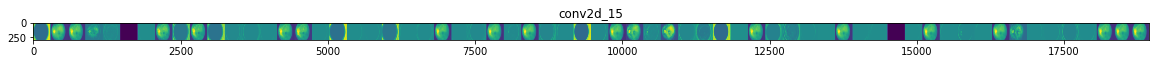

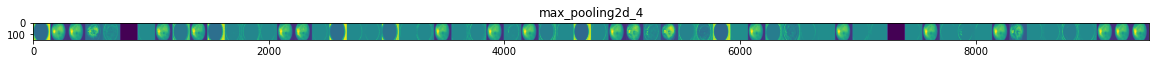

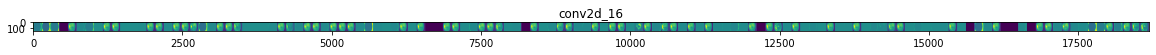

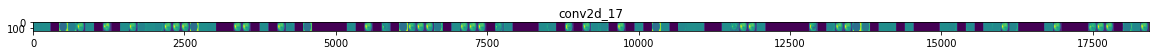

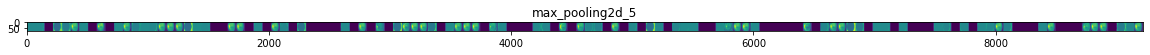

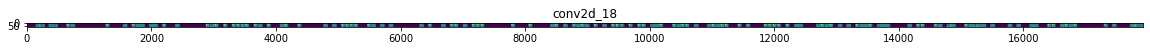

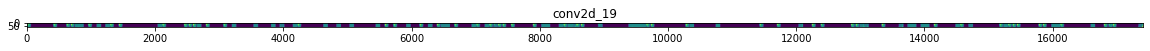

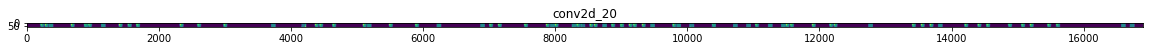

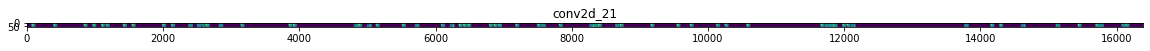

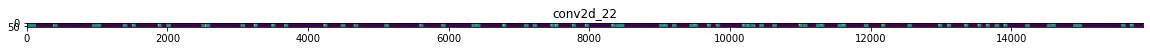

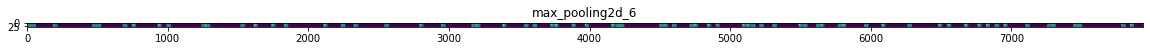

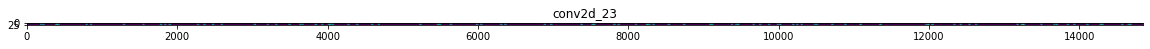

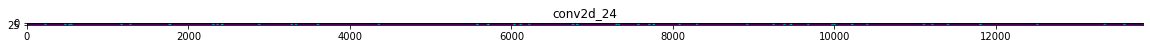

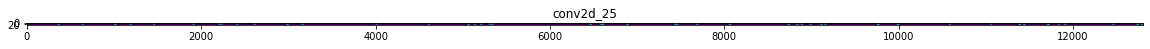

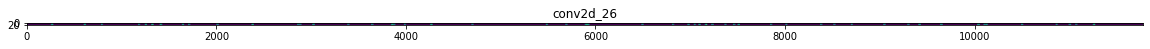

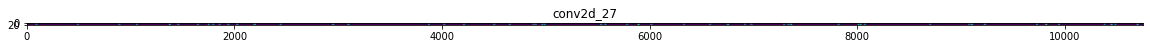

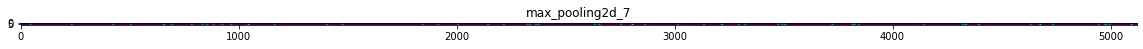

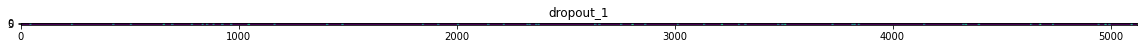

In [ ]:
# Let's define a new Model that will take an image as input, and will output
# intermediate representations for all layers in the previous model after
# the first.
successive_outputs = [layer.output for layer in model.layers[1:]]
#visualization_model = Model(img_input, successive_outputs)
visualization_model = Model(inputs = model.input, outputs = successive_outputs)
# Let's prepare a random input image from the training set.
img_path = random.choice(rand_img_files)

img = load_img(img_path, target_size=(300, 300))  # this is a PIL image
x = img_to_array(img)  # Numpy array with shape (150, 150, 3)
x = x.reshape((1,) + x.shape)  # Numpy array with shape (1, 150, 150, 3)

# Rescale by 1/255
x /= 255

# Let's run our image through our network, thus obtaining all
# intermediate representations for this image.
successive_feature_maps = visualization_model.predict(x)

# These are the names of the layers, so can have them as part of our plot
layer_names = [layer.name for layer in model.layers[1:]]

# Now let's display our representations
for layer_name, feature_map in zip(layer_names, successive_feature_maps):
  if len(feature_map.shape) == 4:
    # Just do this for the conv / maxpool layers, not the fully-connected layers
    n_features = feature_map.shape[-1]  # number of features in feature map
    # The feature map has shape (1, size, size, n_features)
    size = feature_map.shape[1]
    # We will tile our images in this matrix
    display_grid = np.zeros((size, size * n_features))
    for i in range(n_features):
      # Postprocess the feature to make it visually palatable
      x = feature_map[0, :, :, i] 
      x -= x.mean()
      x /= x.std()
      x *= 64
      x += 128
      x = np.clip(x, 0, 255).astype('uint8')
      # We'll tile each filter into this big horizontal grid
      display_grid[:, i * size : (i + 1) * size] = x
    # Display the grid
    scale = 20. / n_features
    plt.figure(figsize=(scale * n_features, scale))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')

In [ ]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history['accuracy']
print("Final Accuracy: ", acc[len(acc)-1]) 
#val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history['loss']
#val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
#plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
#plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
hist_test = model.evaluate(
    test_generator,
    verbose = 1
)
print(hist_test)

4/4 [==============================] - 11s 3s/step - loss: 1.1536 - accuracy: 0.7282
[1.1535719633102417, 0.7281553149223328]


In [ ]:
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  if classes[0]>0.5:
    print(fn + " Presence of DR detected")
  else:
    print(fn + " No DR Detected")

Saving IDRiD_075.jpg to IDRiD_075.jpg
[1.]
IDRiD_075.jpg Presence of DR detected


In [ ]:
new_model = load_model('/content/model2_best.hdf5', compile=False)
new_model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0003), metrics=['accuracy'])
new_model.summary()
pre_weights = new_model.get_weights()
#new_model.load_weights(pre_weights)

In [ ]:
new_hist = new_model.fit(train_generator,
                    validation_data = test_generator,
                    steps_per_epoch = train_generator.samples//train_batch_size,
                    epochs =  50,
                    validation_steps = test_generator.samples//test_batch_size,
                    verbose = 1,
                    callbacks = [checkpoint]
                    )

Epoch 1/50
51/51 [==============================] - ETA: 0s - loss: 0.6326 - accuracy: 0.6741
Epoch 00001: val_accuracy did not improve from 0.68750
51/51 [==============================] - 75s 1s/step - loss: 0.6326 - accuracy: 0.6741 - val_loss: 0.6320 - val_accuracy: 0.6667
Epoch 2/50
51/51 [==============================] - ETA: 0s - loss: 0.6164 - accuracy: 0.6741
Epoch 00002: val_accuracy did not improve from 0.68750
51/51 [==============================] - 73s 1s/step - loss: 0.6164 - accuracy: 0.6741 - val_loss: 0.6379 - val_accuracy: 0.6562
Epoch 3/50
51/51 [==============================] - ETA: 0s - loss: 0.5839 - accuracy: 0.6519
Epoch 00003: val_accuracy did not improve from 0.68750
51/51 [==============================] - 73s 1s/step - loss: 0.5839 - accuracy: 0.6519 - val_loss: 0.6597 - val_accuracy: 0.6458
Epoch 4/50
51/51 [==============================] - ETA: 0s - loss: 0.5620 - accuracy: 0.6543
Epoch 00004: val_accuracy improved from 0.68750 to 0.69792, saving model

KeyboardInterrupt: ignored

In [ ]:
!cp /content/best_model2.hdf5 /content/drive/MyDrive/DRProjectData/best_model2_dr.hdf5

In [ ]:
new_model.save(drive_path+'IDRID_Model_ADV1_state_overfitcutoff.h5')

In [ ]:
hist_df = pd.DataFrame(history.history)

In [ ]:
new_hist_df = pd.DataFrame(new_hist.history)

In [ ]:
hist_csv_file = drive_path+'history_avd1_run3_state1.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
new_hist_df = pd.DataFrame(new_hist.history)
newhist_csv_file = drive_path+'history_state2.csv'
with open(newhist_csv_file, mode='w') as f:
    new_hist_df.to_csv(f)

In [ ]:
model_eval = load_model('/content/best_model.hdf5')
hist_eval = model_eval.evaluate(
    test_generator,
    verbose = 1,
)
print(hist_eval)

13/13 [==============================] - 13s 1s/step - loss: 1.6100 - accuracy: 0.7379
[1.6100096702575684, 0.737864077091217]


In [ ]:
model_eval = load_model('/content/best_model2.hdf5')#(drive_path+'IDRID_Model_ADV1_run2_iter1.h5')
hist_eval = model_eval.evaluate(test_generator,
                                verbose = 1
)
print(hist_eval)

13/13 [==============================] - 13s 1s/step - loss: 3.9628 - accuracy: 0.7282
[3.9628098011016846, 0.7281553149223328]


In [ ]:
count = 0
for img in test_generator:
  classes = new_model.predict(img[0])
  print(count)
  count = count + 1

In [ ]:
print(classes)

In [ ]:
hist1df = pd.read_csv(drive_path + 'history_avd1_run2_state1_ed2.csv', dtype=str)
#hist2df = pd.read_csv(drive_path + 'history_state2.csv', dtype=str)
hist1df.tail(5)

,Unnamed: 0,loss,accuracy,val_loss,val_accuracy
95,95,0.067760728,0.975786924,0.49309513,0.749320386
96,96,0.206652179,0.937045991,0.496952211,0.757281542
97,97,0.125644594,0.953995168,0.49709633,0.748155315
98,98,0.088940099,0.975786924,0.478281983,0.75723785
99,99,0.061232254,0.973365605,0.473095226,0.757282916


In [ ]:
hist2df['Unnamed: 0'] = 100+hist2df['Unnamed: 0'].astype(int)
#print(pd.concat([hist1df,hist2df]))
print(hist2df)

In [ ]:
hist_all = pd.concat([hist1df, hist2df])
hist_all['Unnamed: 0'] = 1 + hist_all['Unnamed: 0'].astype(int)
print(hist_all)

    Unnamed: 0                    loss            accuracy
0            1      0.7100145816802979  0.6435331106185913
1            2      0.6155781745910645  0.6908517479896545
2            3      0.6077686548233032   0.668749988079071
3            4      0.6342977285385132  0.6750788688659668
4            5      0.6694602370262146  0.6719242930412292
..         ...                     ...                 ...
95         196   5.009794108445931e-07                 1.0
96         197  4.0305911852556164e-07                 1.0
97         198  4.3221314172114944e-07                 1.0
98         199  3.3649408237579337e-07                 1.0
99         200  4.5796721792612516e-07                 1.0

[200 rows x 3 columns]


In [ ]:
hist_all = hist_all.rename(columns={'Unnamed: 0': 'epochs'})
print(hist_all)

    epochs                    loss            accuracy
0        1      0.7100145816802979  0.6435331106185913
1        2      0.6155781745910645  0.6908517479896545
2        3      0.6077686548233032   0.668749988079071
3        4      0.6342977285385132  0.6750788688659668
4        5      0.6694602370262146  0.6719242930412292
..     ...                     ...                 ...
95     196   5.009794108445931e-07                 1.0
96     197  4.0305911852556164e-07                 1.0
97     198  4.3221314172114944e-07                 1.0
98     199  3.3649408237579337e-07                 1.0
99     200  4.5796721792612516e-07                 1.0

[200 rows x 3 columns]


In [ ]:
acc  = new_hist['accuracy'].astype(float)
#print("Final Accuracy: ", acc[len(acc)-1]) 
loss  = new_hist['loss'].astype(float)

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
#plt.plot  ( epochs, val_acc )
plt.title ('Training accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Training Accuracy Total', dpi=100)
plt.figure()

#------------------------------------------------
# Plot training loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
#plt.plot  ( epochs, val_loss )
plt.title ('Training loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Training Loss Total', dpi=100)
plt.figure()

TypeError: ignored

<Figure size 432x288 with 0 Axes>

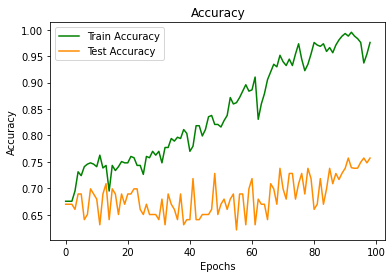

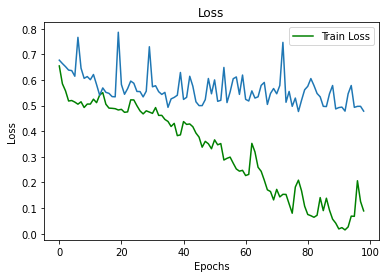

<Figure size 432x288 with 0 Axes>

In [ ]:
h_temp = hist1df.iloc[0:len(hist1df)-1]
acc  = h_temp['accuracy'].astype(float)
val_acc  = h_temp['val_accuracy'].astype(float)
#print("Final Accuracy: ", acc[len(acc)-1]) 
loss  = h_temp['loss'].astype(float)
val_loss  = h_temp['val_loss'].astype(float)
#val_loss = val_loss.reindex(index=val_loss.index[::-1])
epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs, acc, 'green', label = 'Train Accuracy' )
plt.plot  ( epochs, val_acc, 'darkorange', label = 'Test Accuracy')
plt.legend(loc='best')
plt.title ('Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.savefig('Training Accuracy RUN2 Iter1', dpi=100)
plt.figure()

#------------------------------------------------
# Plot training loss per epoch
#------------------------------------------------
plt.plot  ( epochs, loss, 'green', label = 'Train Loss' )
plt.plot  ( epochs, val_loss )
plt.legend(loc='best')
plt.title ('Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.savefig('Training Loss RUN2 Iter1', dpi=100)
plt.figure()

In [ ]:
print(type(hist1df))

<class 'pandas.core.frame.DataFrame'>


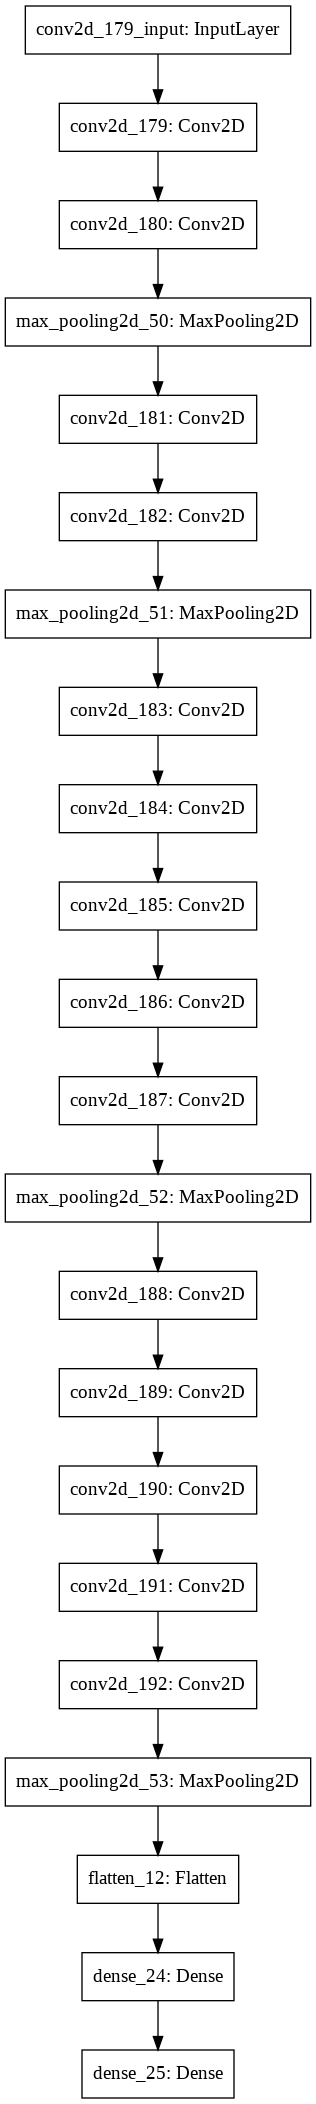

In [ ]:
model_temp = load_model(drive_path+'IDRID_Model_ADV1.h5')
plot(model_temp)

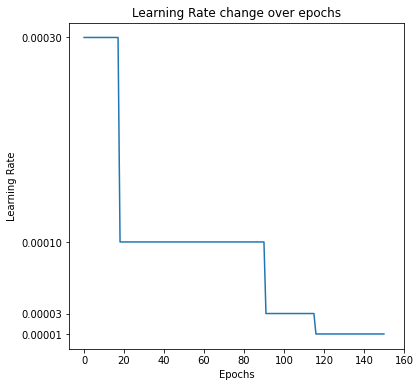

In [ ]:
lr_list = [0.0003, 0.0003, 0.0003, 0.0003, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.0001, 0.00003, 0.00003, 0.00003, 0.00003, 0.00001, 0.00001, 0.00001]
ep_list = [0, 5, 10, 17, 18, 30, 40, 50, 60, 70, 80, 90, 91, 100, 110, 115, 116, 120,150]
fs = 6
plt.figure(figsize=(fs,fs))
plt.plot(ep_list, lr_list)
plt.xticks([0,20,40,60,80,100,120,140,160])
plt.yticks([0.0003, 0.0001, 0.00003, 0.00001])
plt.xlabel('Epochs')
plt.ylabel('Learning Rate')
plt.title('Learning Rate change over epochs')
plt.show()